# Forager

An agent that has competing drives - hide in a safe area or traverse stressful territory to visit food, which resets hunger. Hunger increases at each timestep that it isn't visiting food.

In [53]:
%pip install inferactively-pymdp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [54]:
import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

# Experiment 1 - Competing Drives

- Two goals: Shelter / Food.
- Three hidden states: Location / Hunger / Stress
- States map 1 : 1 with senses (so we make three observations, Loc / Hunger / Stress, with 100% confidence in their mappings to states - identity A Matrix)
- Agent believes that Hunger will increase each turn unless it is on the Food goal, where it resets to zero (offset diagonal B matrix)
- Agent believes that Stress will increase each turn unless it is at the Shelter goal, where it resets to zero (offset diagonal B matrix)
- Agent has exponentially growing dislike for higher Hunger and Stress levels.

The agent knows that by performing it's (mandatory, singular) Hunger action ('eat') at the Food location it will get hunger relief.

The agent knows that by performing it's (mandatory, singular) Stress action ('rest') at the Shelter location it will get stress relief.

Note that it is the action taken *after* landing on the goal that causes the relief, not the one that lands you there.

This must be taken into account when setting policy length, i.e. the agent has to be able to imagine the state one timestep after landing there.

> I tried setting a belief that *landing* there would cause you to see relief by expecting to observe 0 stress/hunger at the relevant goal location (A matrix) and setting it in the env *after* updating location (reward if you arrived). This seems sensible but the problem is that the B matrix can only say 'given where I am, if I act, what happens'. If the agent is in a neighbouring square, the answer to 'what happens' would depend on whether it moved into the goal (reset) or away from the goal (increment). The only way to be deterministic is to say 'you have to act ('eat') *at* the food location'.

The overall result here is that the agent oscillates back and forth between the two goals as its competing drives override each other and it seeks the other kind of relief.

This is purely **extrinsic** reward driven behaviour - the agent sees a state within the policy horizon that provides closer alignment with its preferred state (C matrix).

There is no information in the environment, i.e. no observations that would provide epistemic value which might make the agent more certain about its true state and provide an advantage in reaching the goal.

This means if the agent can't directly see the goal, it has no motivation to move.

The policy length must therefore be 1 more than the Manhatten distance (L1, shortest path) to account for imagining what the state *after* landing there would look like, as explained above.

# Task
Develop and analyze an active inference agent for a camping and foraging task within a custom grid world environment. This involves:

1.  **Environment Setup**: Defining a `4x4` grid with 'food' at `(0,3)` and 'shelter' at `(0,0)`, a maximum hunger level of `5`, and a maximum stress level of `5`.
2.  **Generative Model Design** (Using **Factorized State Space** with `B_factor_list`):
    *   **Hidden State Factors**: `Location` (16 grid points), `Hunger Level` (0-5), and `Stress Level` (0-5) as **separate factors**.
    *   **Observations**: `Location Observation`, `Hunger Sensor`, and `Stress Sensor`.
    *   **`A` Matrix**: Multi-dimensional arrays mapping states to observations, with location-dependent perception (satiated at food, safe at shelter).
    *   **`B` Matrix** with **`B_factor_list`**: 
        - `B[0]` (Location): Standard 5-action movement, depends only on Location.
        - `B[1]` (Hunger): **Location-dependent** transitions via `B_factor_list=[[0], [0,1], [0,2]]` - resets at food, otherwise increases.
        - `B[2]` (Stress): **Location-dependent** transitions - resets at shelter, otherwise increases.
    *   **`C` Vector**: Preferences for low hunger and low stress observations.
    *   **`D` Vector**: Initial belief of starting location with hunger 0 and stress 0.
3.  **Generative Process (`GridWorldEnv`)**: Implementing a custom class that simulates true environment dynamics.
4.  **Simulation & Analysis**: Running a simulation, tracking the agent's path, hunger, and stress, visualizing the results.

**Key Advantage**: Factorized state space with `B_factor_list` scales as O(n) instead of O(n³), making larger grids and longer policy horizons tractable.

## Define Environment Parameters

### Subtask:
Establish the grid dimensions, specific locations for 'food' and 'shelter' squares, a maximum hunger level, and how stress factors will be assigned to non-shelter squares. Also define the mapping of linear indices to (y,x) coordinates for the grid.

**Reasoning**:
The user provided specific instructions for defining the environment parameters, including grid dimensions, food/shelter locations, max hunger, and risk factors. I will generate the Python code to set up these parameters as specified.



In [55]:
# Scalable grid world configuration
grid_dims = [7, 7]  # 7x7 grid (49 locations)
max_hunger = 10      # 0-7 (8 levels)
max_stress = 10        # 0-7 (8 levels)

shelter_location = (0, 0) # Top-left corner
food_location = (3, 0) # Food is 4 steps down from shelter

num_grid_points = int(np.prod(grid_dims))  # 25 grid locations

# Create a look-up table `loc_list` that maps linear indices to (y, x) coordinates
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

distance = abs(food_location[0]-shelter_location[0]) + abs(food_location[1]-shelter_location[1])

print(f"Grid Dimensions: {grid_dims}")
print(f"Maximum Hunger/Stress Level: {max_hunger}")
print(f"Food Location: {food_location}")
print(f"Shelter Location: {shelter_location}")
print(f"Manhattan distance: {distance} steps") # Without a 'reward trail', policies must be at least the manhattan distance from the goal to see any (extrinsic) reward signal.

Grid Dimensions: [7, 7]
Maximum Hunger/Stress Level: 10
Food Location: (3, 0)
Shelter Location: (0, 0)
Manhattan distance: 3 steps


## Define Hidden State Factors

### Subtask:
Specify the agent's hidden state factors (`num_states`). You will need three factors: 1) Location (the agent's position in the grid), 2) Hunger Level (discrete levels from 0 to `max_hunger`), and 3) Stress Level (discrete levels from 0 to `max_stress`).

#### Instructions
1. Define `hunger_levels` and `stress_levels` as NumPy arrays ranging from 0 to their respective max values.
2. Create `num_states = [num_grid_points, num_hunger, num_stress]` as **three separate factors** (not unified).
3. This factorized representation scales linearly O(n) instead of O(n³) with the unified approach.

**Reasoning**:
Using a **factorized state space** with `B_factor_list` instead of a unified state space. This keeps Location, Hunger, and Risk as separate factors while still allowing location-dependent dynamics through the transition model dependencies.

In [56]:
hunger_levels = np.arange(max_hunger + 1)  # 0 to max_hunger, inclusive
stress_levels = np.arange(max_stress + 1)  # 0 to max_stress, inclusive

# Pre-compute indices for special locations
food_idx = loc_list.index(food_location)
shelter_idx = loc_list.index(shelter_location)

# FACTORIZED STATE SPACE: Keep Location, Hunger, Stress as separate factors
# Use B_factor_list to encode location-dependent transitions for hunger/stress
num_hunger = len(hunger_levels)
num_stress = len(stress_levels)

# Hidden state factors: [Location, Hunger, Stress]
num_states = [num_grid_points, num_hunger, num_stress]

print(f"Factorized State Space:")
print(f"  Factor 0 (Location): {num_grid_points} states")
print(f"  Factor 1 (Hunger): {num_hunger} states (0-{max_hunger})")
print(f"  Factor 2 (Stress): {num_stress} states (0-{max_stress})")
print(f"  Total: {num_grid_points} + {num_hunger} + {num_stress} = {sum(num_states)} parameters")
print(f"  (vs unified: {num_grid_points * num_hunger * num_stress} states)")
print(f"\nFood at index {food_idx} {food_location}, Shelter at index {shelter_idx} {shelter_location}")

Factorized State Space:
  Factor 0 (Location): 49 states
  Factor 1 (Hunger): 11 states (0-10)
  Factor 2 (Stress): 11 states (0-10)
  Total: 49 + 11 + 11 = 71 parameters
  (vs unified: 5929 states)

Food at index 21 (3, 0), Shelter at index 0 (0, 0)


## Define Observation Modalities

### Subtask:
Specify the agent's observation modalities (`num_obs`). You will need three modalities: 1) Location Observation (the agent observes its position), 2) Hunger Sensor (the agent observes its internal hunger state), and 3) Stress Sensor (the agent observes its internal stress state).

**Reasoning**:
I will define the names for each observation modality and then create the `num_obs` list based on their dimensionalities, as specified in the instructions. This will complete the subtask of specifying the observation modalities.



In [57]:
location_obs_names = [f"({y},{x})" for y,x in loc_list] # For Location Observation
hunger_sensor_names = ['full'] + [f'hunger_{h}' for h in range(1, max_hunger + 1)] # 'full' is hunger_0
stress_sensor_names = ['safe'] + [f'stress_{r}' for r in range(1, max_stress + 1)] # 'safe' is stress_0

# Observation modalities and their levels
num_obs = [
    num_grid_points, # Location Observation (number of grid points)
    len(hunger_sensor_names), # Hunger Sensor (full, hunger_1, ..., hunger_max_hunger)
    len(stress_sensor_names) # Stress Sensor (safe, stress_1, ..., stress_max_stress)
]

print(f"Observation Dimensionalities (Location, Hunger Sensor, Stress Sensor): {num_obs}")
print(f"Hunger Sensor Names: {hunger_sensor_names}")
print(f"Stress Sensor Names: {stress_sensor_names}")

Observation Dimensionalities (Location, Hunger Sensor, Stress Sensor): [49, 11, 11]
Hunger Sensor Names: ['full', 'hunger_1', 'hunger_2', 'hunger_3', 'hunger_4', 'hunger_5', 'hunger_6', 'hunger_7', 'hunger_8', 'hunger_9', 'hunger_10']
Stress Sensor Names: ['safe', 'stress_1', 'stress_2', 'stress_3', 'stress_4', 'stress_5', 'stress_6', 'stress_7', 'stress_8', 'stress_9', 'stress_10']


## Design Observation Model (A matrix)

### Subtask:
Construct the `A` matrix, paying close attention to dependencies for each observation modality.


**Reasoning**:
For the factorized state space, each A matrix has shape `(num_obs[m], num_states[0], num_states[1], num_states[2])`, i.e., observation dimension × all state factor dimensions. This allows observations to depend on any combination of hidden state factors.

In [58]:
# A matrix shapes for factorized state space:
# Each A[m] has shape (num_obs[m], num_states[0], num_states[1], num_states[2])
# i.e., (num_obs[m], num_locations, num_hunger, num_stress)

A_m_shapes = [[num_obs[m]] + num_states for m in range(len(num_obs))]
A = utils.obj_array_zeros(A_m_shapes)

print(f"Building A matrices for factorized state space...")
print(f"  A[0] Location obs shape: {A[0].shape}")
print(f"  A[1] Hunger sensor shape: {A[1].shape}")
print(f"  A[2] Stress sensor shape: {A[2].shape}")

# Fill A matrices
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_stress):
            # A[0] - Location Observation: identity mapping for location
            A[0][loc_idx, loc_idx, h, r] = 1.0
            
            # A[1] - Hunger Sensor
            A[1][h, loc_idx, h, r] = 1.0  # True hunger
            
            # A[2] - Stress Sensor
            # At shelter: always observe 'safe' (index 0)
            # Elsewhere: observe true stress level
            A[2][r, loc_idx, h, r] = 1.0  # True stress

print("\nAll A matrices filled.")
print("  Food location -> always 'satiated' observation")
print("  Shelter location -> always 'safe' observation")

# Verification: check normalization
all_normalized = True
for m in range(len(A)):
    # Sum over observation dimension (axis 0) should be 1 for all state configs
    sum_over_obs = A[m].sum(axis=0)
    is_norm_m = np.allclose(sum_over_obs, 1.0)
    if not is_norm_m:
        print(f"Warning: A[{m}] is NOT normalized!")
        all_normalized = False
print(f"All A sub-arrays are normalized: {all_normalized}")

Building A matrices for factorized state space...
  A[0] Location obs shape: (49, 49, 11, 11)
  A[1] Hunger sensor shape: (11, 49, 11, 11)
  A[2] Stress sensor shape: (11, 49, 11, 11)

All A matrices filled.
  Food location -> always 'satiated' observation
  Shelter location -> always 'safe' observation
All A sub-arrays are normalized: True


## Design Transition Model (B matrix)

### Subtask:
Construct the `B` matrix using **`B_factor_list`** to encode location-dependent dynamics while keeping the state space factorized.

#### Key Concept: B_factor_list
The `B_factor_list` parameter specifies which hidden state factors each transition matrix depends on:
- `B_factor_list = [[0], [0, 1], [0, 2]]` means:
  - `B[0]` (Location) depends only on Location (factor 0) - standard movement
  - `B[1]` (Hunger) depends on Location AND Hunger - **location-dependent transitions!**
  - `B[2]` (Stress) depends on Location AND Stress - **location-dependent transitions!**

This allows encoding that:
- Hunger resets to 0 when at the food location
- Stress resets to 0 when at the shelter location

...while keeping the state space factorized (scalable).

**Reasoning**:
With the factorized approach:
- `num_controls = [5, 1, 1]` - Location has 5 movement actions, Hunger and Risk have 1 null action each (uncontrollable)
- `B_factor_list = [[0], [0, 1], [0, 2]]` - specifies dependencies for location-dependent dynamics
- `control_fac_idx = [0]` - only Location factor is under agent's control

B matrix shapes follow the pattern: `(next_state, *parent_factor_dims, num_actions)`
- For B_factor_list[1] = [0, 1]: B[1] has shape `(6, 16, 6, 1)` = `(next_hunger, location, curr_hunger, 1 action)`
- For B_factor_list[2] = [0, 2]: B[2] has shape `(6, 16, 6, 1)` = `(next_risk, location, curr_risk, 1 action)`

In [59]:
# FACTORIZED TRANSITION MODEL
# num_controls: actions per factor - only Location (factor 0) is controllable
num_controls = [5, 1, 1]  # 5 movement actions, 1 null action for hunger, 1 null action for stress

# B_factor_list specifies which state factors each B matrix depends on:
# - B[0] (Location): depends only on Location (factor 0) - standard
# - B[1] (Hunger): depends on Location (factor 0) AND Hunger (factor 1) - location-dependent!
# - B[2] (Stress): depends on Location (factor 0) AND Stress (factor 2) - location-dependent!
B_factor_list = [[0], [0, 1], [0, 2]]

# Specify only Location (factor 0) is controllable by agent
control_fac_idx = [0]

# Initialize B matrices with appropriate shapes
# Shape pattern: (next_state, *parent_factor_dims, num_actions)
# For B_factor_list = [[0], [0, 1], [0, 2]]:
# B[0]: (16, 16, 5) - next_loc, curr_loc, 5 actions
# B[1]: (6, 16, 6, 1) - next_hunger, curr_loc (factor 0), curr_hunger (factor 1), 1 null action
# B[2]: (6, 16, 6, 1) - next_stress, curr_loc (factor 0), curr_stress (factor 2), 1 null action

B = utils.obj_array(len(num_states))
B[0] = np.zeros((num_grid_points, num_grid_points, num_controls[0]))  # (16, 16, 5)
B[1] = np.zeros((num_hunger, num_grid_points, num_hunger, num_controls[1]))  # (6, 16, 6, 1)
B[2] = np.zeros((num_stress, num_grid_points, num_stress, num_controls[2]))  # (6, 16, 6, 1)

print("B matrices initialized for factorized state space:")
print(f"  B[0] Location: {B[0].shape} - depends on [Location]")
print(f"  B[1] Hunger: {B[1].shape} - depends on [Location, Hunger]")
print(f"  B[2] Stress: {B[2].shape} - depends on [Location, Stress]")
print(f"\nB_factor_list: {B_factor_list}")
print(f"control_fac_idx: {control_fac_idx}")

B matrices initialized for factorized state space:
  B[0] Location: (49, 49, 5) - depends on [Location]
  B[1] Hunger: (11, 49, 11, 1) - depends on [Location, Hunger]
  B[2] Stress: (11, 49, 11, 1) - depends on [Location, Stress]

B_factor_list: [[0], [0, 1], [0, 2]]
control_fac_idx: [0]


#### Instructions
1. Fill out `B[0]` (Location transitions):
    * Iterate through each of the 5 possible actions (UP, DOWN, LEFT, RIGHT, STAY).
    * For each action and current location, calculate the next location based on grid boundaries.
    * Set `B[0][next_loc, curr_loc, action_id] = 1.0` for deterministic transitions.

**Reasoning**:
Filling `B[0]` with standard grid movement transitions. This factor only depends on itself (not on hunger or risk), which is reflected in `B_factor_list[0] = [0]`.

In [60]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

print("Filling B[0] - Location transitions...")

# B[0]: Location factor transitions based on movement actions
for action_id, action_label in enumerate(actions):
    for curr_loc_idx in range(num_grid_points):
        curr_y, curr_x = loc_list[curr_loc_idx]
        
        # Compute next location based on action
        if action_label == "UP":
            next_y = curr_y - 1 if curr_y > 0 else curr_y
            next_x = curr_x
        elif action_label == "DOWN":
            next_y = curr_y + 1 if curr_y < (grid_dims[0]-1) else curr_y
            next_x = curr_x
        elif action_label == "LEFT":
            next_y = curr_y
            next_x = curr_x - 1 if curr_x > 0 else curr_x
        elif action_label == "RIGHT":
            next_y = curr_y
            next_x = curr_x + 1 if curr_x < (grid_dims[1]-1) else curr_x
        elif action_label == "STAY":
            next_y, next_x = curr_y, curr_x
        
        next_loc = (next_y, next_x)
        next_loc_idx = loc_list.index(next_loc)
        
        # Set transition probability
        B[0][next_loc_idx, curr_loc_idx, action_id] = 1.0

print("B[0] Location transitions complete!")
print(f"  Actions: {actions}")

# Verify normalization
for action_id in range(5):
    col_sums = B[0][:, :, action_id].sum(axis=0)
    if not np.allclose(col_sums, 1.0):
        print(f"  Warning: B[0][:,:,{action_id}] not normalized!")
print("  B[0] verified: all columns sum to 1")

Filling B[0] - Location transitions...
B[0] Location transitions complete!
  Actions: ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']
  B[0] verified: all columns sum to 1


#### Instructions
1. Fill out `B[1]` (Hunger transitions) - **Location-dependent**:
    * Shape: `(num_hunger, num_hunger, num_locations, 1)` - depends on both location and hunger.
    * At food location: hunger resets to 0 regardless of current hunger.
    * Elsewhere: hunger increases by 1, capped at `max_hunger`.
2. Fill out `B[2]` (Stress transitions) - **Location-dependent**:
    * Shape: `(num_stress, num_stress, num_locations, 1)` - depends on both location and stress.
    * At shelter location: stress resets to 0 regardless of current stress.
    * Elsewhere: stress increases by 1, capped at `max_stress`.

**Reasoning**:
This is where `B_factor_list` enables the key behavior:
- `B[1]` has shape that includes the location dimension, allowing hunger to reset specifically at the food location.
- `B[2]` similarly depends on location, allowing risk to reset at the shelter.
This achieves location-dependent dynamics while keeping the state space factorized!

In [61]:
# B[1] - Hunger transitions: LOCATION-DEPENDENT!
# Shape: (num_hunger, num_locations, num_hunger, 1 null action)
# Indexed as: B[1][next_hunger, location, curr_hunger, action]
# - At food location: hunger resets to 0
# - Elsewhere: hunger increases by 1 (capped at max)

print("Filling B[1] - Hunger transitions (location-dependent)...")

for loc_idx in range(num_grid_points):
    for curr_hunger in range(num_hunger):
        if loc_idx == food_idx:
            # AT FOOD: hunger resets to 0 regardless of current hunger
            next_hunger = 0
        else:
            # ELSEWHERE: hunger increases by 1, capped at max
            next_hunger = min(curr_hunger + 1, max_hunger)
        
        # Single null action (action_id=0)
        B[1][next_hunger, loc_idx, curr_hunger, 0] = 1.0

print(f"  At food (loc {food_idx}): hunger -> 0")
print(f"  Elsewhere: hunger -> min(hunger+1, {max_hunger})")

# B[2] - Stress transitions: LOCATION-DEPENDENT!
# Shape: (num_stress, num_locations, num_stress, 1 null action)
# Indexed as: B[2][next_stress, location, curr_stress, action]
# - At shelter location: stress resets to 0
# - Elsewhere: stress increases by 1 (capped at max)

print("\nFilling B[2] - Stress transitions (location-dependent)...")

for loc_idx in range(num_grid_points):
    for curr_stress in range(num_stress):
        if loc_idx == shelter_idx:
            # AT SHELTER: stress resets to 0 regardless of current stress
            next_stress = 0
        else:
            # ELSEWHERE: stress increases by 1, capped at max
            next_stress = min(curr_stress + 1, max_stress)
        
        # Single null action (action_id=0)
        B[2][next_stress, loc_idx, curr_stress, 0] = 1.0

print(f"  At shelter (loc {shelter_idx}): stress -> 0")
print(f"  Elsewhere: stress -> min(stress+1, {max_stress})")

# Verify all B matrices
print("\nVerifying B matrix normalization...")
for f, factor_name in enumerate(['Location', 'Hunger', 'Stress']):
    # Check that columns sum to 1 for all control/parent configurations
    B_f = B[f]
    # Sum over first axis (next state)
    total_axes = tuple(range(1, len(B_f.shape)))  # All axes except the first
    for idx in np.ndindex(B_f.shape[1:]):
        col_sum = B_f[(slice(None),) + idx].sum()
        if not np.isclose(col_sum, 1.0):
            print(f"  Warning: B[{f}] column at {idx} sums to {col_sum:.3f}")
print("All B matrices verified!")

print("\n=== FACTORIZED DYNAMICS SUMMARY ===")
print(f"Location transitions: standard grid movement (5 actions)")
print(f"Hunger transitions: +1 per step, reset to 0 at food {food_location}")
print(f"Stress transitions: +1 per step, reset to 0 at shelter {shelter_location}")

Filling B[1] - Hunger transitions (location-dependent)...
  At food (loc 21): hunger -> 0
  Elsewhere: hunger -> min(hunger+1, 10)

Filling B[2] - Stress transitions (location-dependent)...
  At shelter (loc 0): stress -> 0
  Elsewhere: stress -> min(stress+1, 10)

Verifying B matrix normalization...
All B matrices verified!

=== FACTORIZED DYNAMICS SUMMARY ===
Location transitions: standard grid movement (5 actions)
Hunger transitions: +1 per step, reset to 0 at food (3, 0)
Stress transitions: +1 per step, reset to 0 at shelter (0, 0)


## Prior Preferences (C vector)

### Subtask:
Define the agent's prior preferences (`C` vector). This involves setting high positive preferences for observations associated with well-being (e.g., low hunger, low stress) and high negative preferences for observations associated with undesirable states (e.g., high hunger, high stress).

#### Instructions
1. Initialize the `C` vector as an object array with all zeros, using `utils.obj_array_zeros` and `num_obs`.
2. Set preferences for the `Hunger Sensor` observation modality (`C[1]`):
    * Assign a high positive value to `'satiated'` (hunger 0).
    * Assign moderate positive values to low hunger levels.
    * Assign negative values to moderate hunger levels.
    * Assign a high negative value to `max_hunger`.
3. Set preferences for the `Stress Sensor` observation modality (`C[3]`):
    * Use the same preference distribution as hunger - positive for 'safe', increasingly negative for higher stress levels.

**Reasoning**:
I will now initialize the `C` vector and set the preferences for the `Hunger Sensor` and `Risk Feedback` observation modalities, as per the instructions in the previous markdown block.



In [62]:
C = utils.obj_array_zeros(num_obs)

penalty_max = -50.0
exp_steepness = 4

# Hunger Preferences
n_hunger = len(C[1])
C[1][-1] = penalty_max # max hunger - CATASTROPHIC!
if n_hunger > 2:
    for i in range(0, n_hunger): # Max already set, we are filling from 0 to max-1
        denominator = (n_hunger) - 1
        progress = i / denominator if denominator > 0 else 1.0 # Progress from 0 to 1 across the hunger levels (excluding max)
        
        # Exponential scaling: (e^(kx) - 1) / (e^k - 1)
        # Result: Low penalty for low hunger, massive penalty for high hunger
        scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
        C[1][i] = penalty_max * scale

# Stress Preferences - symmetrical with hunger
n_stress = len(C[2])
C[2][-1] = penalty_max
if n_stress > 2:
    for i in range(0, n_stress - 1):
        denominator = (n_stress) - 1
        progress = i / denominator if denominator > 0 else 1.0
        scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
        C[2][i] = penalty_max * scale

print("C (prior preferences) vector filled.")
print(f"Hunger preferences: {np.round(C[1], 2)}")
print(f"Stress preferences: {np.round(C[2], 2)}")
print("\nPreferences scaled automatically to state space dimensions.")

C (prior preferences) vector filled.
Hunger preferences: [ -0.    -0.46  -1.14  -2.16  -3.69  -5.96  -9.35 -14.41 -21.95 -33.21
 -50.  ]
Stress preferences: [ -0.    -0.46  -1.14  -2.16  -3.69  -5.96  -9.35 -14.41 -21.95 -33.21
 -50.  ]

Preferences scaled automatically to state space dimensions.


## Design Prior Over Initial States (D vector)

### Subtask:
Specify the agent's prior over initial hidden states, the `D` array.

#### Instructions
1. Initialize `D` with uniform priors for each of the 3 factors using `utils.obj_array_uniform(num_states)`.
2. Set `D[0]` - Location: one-hot belief for starting position.
3. Set `D[1]` - Hunger: one-hot belief for initial hunger level (0 = satiated).
4. Set `D[2]` - Stress: one-hot belief for initial stress level (0 = safe).

**Reasoning**:
With factorized states, `D` has 3 separate priors - one for each factor. Each is a one-hot vector specifying the agent's belief about its initial state for that factor.

In [63]:
# D vector for factorized state space - one prior per factor
D = utils.obj_array_uniform(num_states)

# Set agent's initial beliefs:
# - Location: center of grid (2,2)
# - Hunger: 0 (satiated)
# - Stress: 0 (safe)
start_loc = (2, 2)
start_loc_idx = loc_list.index(start_loc)
start_hunger = 0
start_stress = 0

# One-hot vectors for each factor
D[0] = utils.onehot(start_loc_idx, num_grid_points)  # Location
D[1] = utils.onehot(start_hunger, num_hunger)        # Hunger
D[2] = utils.onehot(start_stress, num_stress)            # Stress

print("D (prior over initial hidden states) vector filled.")
print(f"  D[0] Location: starts at {start_loc} (idx {start_loc_idx})")
print(f"  D[1] Hunger: starts at {start_hunger}")
print(f"  D[2] Stress: starts at {start_stress}")

D (prior over initial hidden states) vector filled.
  D[0] Location: starts at (2, 2) (idx 16)
  D[1] Hunger: starts at 0
  D[2] Stress: starts at 0


## Implement Generative Process (Environment)

### Subtask:
Create a custom `GridWorldEnv` class. This class will handle the true dynamics of the environment: tracking the agent's actual location, implementing hunger increment/reset rules, generating stress feedback based on randomly assigned stress factors for non-shelter squares, and returning the correct multi-modal observations to the agent based on its actions and the environment's state.

**Reasoning**:
I will define the `GridWorldEnv` class with `__init__`, `step`, and `reset` methods as specified in the instructions, implementing the environment's true dynamics for location, hunger, and observation generation.



In [64]:
class GridWorldEnv():

    def __init__(self, starting_loc, initial_hunger, initial_stress, food_location, shelter_location, 
                 grid_dims, max_hunger, max_stress, loc_list, hunger_levels, stress_levels,
                 hunger_sensor_names, stress_sensor_names):
        self.init_loc = starting_loc
        self.init_hunger = initial_hunger
        self.init_stress = initial_stress
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_stress = self.init_stress

        self.food_location = food_location
        self.shelter_location = shelter_location
        self.grid_dims = grid_dims
        self.max_hunger = max_hunger
        self.max_stress = max_stress
        self.loc_list = loc_list
        self.hunger_levels = hunger_levels
        self.stress_levels = stress_levels
        self.hunger_sensor_names = hunger_sensor_names
        self.stress_sensor_names = stress_sensor_names

        print(f'Environment Initialized: Starting location is {self.init_loc}, Initial hunger is {self.init_hunger}, Initial stress is {self.init_stress}')

    def step(self, action_label):
        # Important - MUST be above location update as hunger and stress reset based on acting *from* food / shelter, not *to* it.

        # Update hunger - resets taking any action in food, otherwise increases
        if self.current_location == self.food_location:
            self.current_hunger = 0
        else:
            self.current_hunger = min(self.current_hunger + 1, self.max_hunger)

        # Update stress - resets taking any action in shelter, otherwise increases
        if self.current_location == self.shelter_location:
            self.current_stress = 0
        else:
            self.current_stress = min(self.current_stress + 1, self.max_stress)

        Y, X = self.current_location
        if action_label == "UP":
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X
        elif action_label == "DOWN":
          Y_new = Y + 1 if Y < (self.grid_dims[0]-1) else Y
          X_new = X
        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X
        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X + 1 if X < (self.grid_dims[1]-1) else X
        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new) # store the new grid location

        # Generate observations
        loc_obs = self.current_location

        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        stress_obs = self.stress_sensor_names[self.stress_levels.tolist().index(self.current_stress)]

        return loc_obs, hunger_obs, stress_obs

    def reset(self):
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_stress = self.init_stress
        print(f'Environment Reset: Location to {self.init_loc}, Hunger to {self.init_hunger}, Stress to {self.init_stress}')

        # Generate initial observations after reset
        loc_obs = self.current_location
        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        stress_obs = self.stress_sensor_names[self.stress_levels.tolist().index(self.current_stress)]

        return loc_obs, hunger_obs, stress_obs

## Run Active Inference Simulation

### Subtask:
Initialize the `Agent` with the designed A, B, C, D matrices and the `GridWorldEnv` instance. Run a simulation loop where the agent infers states, infers policies, selects an action, and the environment provides new observations, tracking the agent's path and hunger over time.

**Reasoning**:
The Agent is initialized with:
- `B_factor_list` to specify location-dependent transitions for hunger and risk
- `control_fac_idx` to specify only the Location factor is controllable

The agent then performs active inference: inferring states from observations, evaluating policies based on expected free energy, and selecting actions to balance hunger and risk preferences.

In [65]:
from pymdp.agent import Agent

# 1. Instantiate the GridWorldEnv class
# Start somewhere interesting - between food and shelter
starting_loc = (0, 1)  # Top row, one step from shelter
initial_hunger = 0
initial_stress = 0

my_env = GridWorldEnv(
    starting_loc=starting_loc,
    initial_hunger=initial_hunger,
    initial_stress=initial_stress,
    food_location=food_location,
    shelter_location=shelter_location,
    grid_dims=grid_dims,
    max_hunger=max_hunger,
    max_stress=max_stress,
    loc_list=loc_list,
    hunger_levels=hunger_levels,
    stress_levels=stress_levels,
    hunger_sensor_names=hunger_sensor_names,
    stress_sensor_names=stress_sensor_names
)

# 2. Call the reset() method on the environment instance
loc_obs, hunger_obs, stress_obs = my_env.reset()

# 3. Convert initial observations from semantic names to numerical indices
obs = [
    loc_list.index(loc_obs),
    hunger_sensor_names.index(hunger_obs),
    stress_sensor_names.index(stress_obs)
]

# 4. Update D to match actual starting state
start_loc_idx = loc_list.index(starting_loc)
D[0] = utils.onehot(start_loc_idx, num_grid_points)
D[1] = utils.onehot(initial_hunger, num_hunger)
D[2] = utils.onehot(initial_stress, num_stress)

# 5. Initialize the Agent with FACTORIZED model
# Key parameters:
#   - B_factor_list: specifies which factors each B matrix depends on
#   - control_fac_idx: specifies only Location is controllable
policy_len = 4

my_agent = Agent(
    A=A, 
    B=B, 
    C=C, 
    D=D,
    policy_len=policy_len,
    B_factor_list=B_factor_list,
    control_fac_idx=control_fac_idx
)

# 6. Create empty lists to store the history
history_of_locs = [loc_obs]
history_of_hunger = [my_env.current_hunger]
history_of_stress = [my_env.current_stress]

# 7. Simulation parameters
T = 20  # number of timesteps

print(f"\n=== FACTORIZED STATE SPACE SIMULATION ===")
print(f"State factors: {num_states} (Location × Hunger × Stress)")
print(f"Total parameters: {sum(num_states)} (vs unified: {np.prod(num_states)})")
print(f"Starting at {starting_loc}, Hunger={initial_hunger}, Stress={initial_stress}")
print(f"Food at {food_location} (resets hunger), Shelter at {shelter_location} (resets stress)")
print(f"Policy length: {policy_len}")
print(f"B_factor_list: {B_factor_list}")
print(f"Running {T} timesteps...")

# 8. Start a simulation loop
for t in range(T):
    print(f"\n--- Timestep {t+1}/{T} ---")
    qs = my_agent.infer_states(obs)
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    
    # For factorized model, chosen_action_id[0] is the movement action
    # (hunger and stress factors are uncontrollable, so their "actions" are null)
    movement_id = int(chosen_action_id[0])
    choice_action = actions[movement_id]

    print(f'Chosen action: {choice_action}')

    loc_obs, hunger_obs, stress_obs = my_env.step(choice_action)

    obs = [
        loc_list.index(loc_obs),
        hunger_sensor_names.index(hunger_obs),
        stress_sensor_names.index(stress_obs)
    ]

    history_of_locs.append(loc_obs)
    history_of_hunger.append(my_env.current_hunger)
    history_of_stress.append(my_env.current_stress)

    print(f'Location: {loc_obs}, Hunger: {my_env.current_hunger}, Stress: {my_env.current_stress}')
    if loc_obs == food_location:
        print("  -> AT FOOD!")
    if loc_obs == shelter_location:
        print("  -> AT SHELTER!")

print("\nSimulation finished.")

Environment Initialized: Starting location is (0, 1), Initial hunger is 0, Initial stress is 0
Environment Reset: Location to (0, 1), Hunger to 0, Stress to 0

=== FACTORIZED STATE SPACE SIMULATION ===
State factors: [49, 11, 11] (Location × Hunger × Stress)
Total parameters: 71 (vs unified: 5929)
Starting at (0, 1), Hunger=0, Stress=0
Food at (3, 0) (resets hunger), Shelter at (0, 0) (resets stress)
Policy length: 4
B_factor_list: [[0], [0, 1], [0, 2]]
Running 20 timesteps...

--- Timestep 1/20 ---
Chosen action: LEFT
Location: (0, 0), Hunger: 1, Stress: 1
  -> AT SHELTER!

--- Timestep 2/20 ---
Chosen action: DOWN
Location: (1, 0), Hunger: 2, Stress: 0

--- Timestep 3/20 ---
Chosen action: DOWN
Location: (2, 0), Hunger: 3, Stress: 1

--- Timestep 4/20 ---
Chosen action: DOWN
Location: (3, 0), Hunger: 4, Stress: 2
  -> AT FOOD!

--- Timestep 5/20 ---
Chosen action: UP
Location: (2, 0), Hunger: 0, Stress: 3

--- Timestep 6/20 ---
Chosen action: UP
Location: (1, 0), Hunger: 1, Stress: 4

## Visualize Agent's Journey

Let's visualize the agent's path through the grid, showing the food and shelter locations, and the stress map.

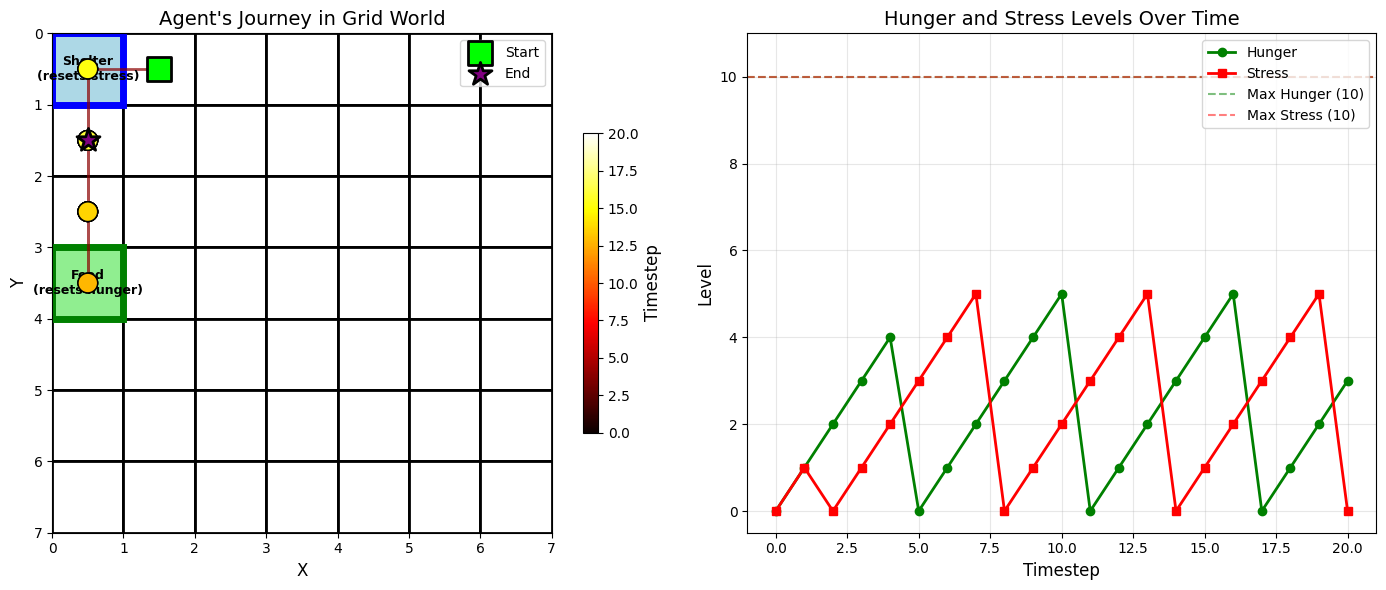


Journey Summary:
  Start: (0, 1), Hunger: 0, Stress: 0
  End: (1, 0), Hunger: 3, Stress: 0
  Total steps: 20
  Times at food: 3
  Times at shelter: 4


In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import numpy as np

# Convert history of locations to numpy array
all_locations = np.vstack(history_of_locs).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Grid with agent path
ax = axes[0]

# Create grid with pcolormesh for the background
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', linewidth=2, facecolor='white')

# Draw grid squares
for y in range(grid_dims[0]):
    for x in range(grid_dims[1]):
        rect = patches.Rectangle((x, y), 1.0, 1.0, linewidth=2, 
                                  edgecolor='k', facecolor='white')
        ax.add_patch(rect)

ax.invert_yaxis()

# Mark food location (green)
food_rect = patches.Rectangle((food_location[1], food_location[0]), 1.0, 1.0, 
                               linewidth=5, edgecolor='green', facecolor='lightgreen')
ax.add_patch(food_rect)
ax.text(food_location[1]+0.5, food_location[0]+0.5, 'Food\n(resets hunger)', fontsize=9, 
        ha='center', va='center', fontweight='bold')

# Mark shelter location (blue)  
shelter_rect = patches.Rectangle((shelter_location[1], shelter_location[0]), 1.0, 1.0,
                                  linewidth=5, edgecolor='blue', facecolor='lightblue')
ax.add_patch(shelter_rect)
ax.text(shelter_location[1]+0.5, shelter_location[0]+0.5, 'Shelter\n(resets stress)', fontsize=9,
        ha='center', va='center', fontweight='bold')

# Plot the agent's path
ax.plot(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 'darkred', linewidth=2, zorder=2, alpha=0.7)

# Color the dots by time
temporal_colormap = cm.hot(np.linspace(0, 0.8, len(all_locations)))
dots = ax.scatter(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 200, 
                  c=temporal_colormap, zorder=3, edgecolors='black', linewidth=1)

# Mark start and end positions
ax.scatter(all_locations[0,1]+0.5, all_locations[0,0]+0.5, 300, c='lime', 
           marker='s', zorder=4, edgecolors='black', linewidth=2, label='Start')
ax.scatter(all_locations[-1,1]+0.5, all_locations[-1,0]+0.5, 300, c='purple',
           marker='*', zorder=4, edgecolors='black', linewidth=2, label='End')

sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=T))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Timestep', fontsize=12)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0, grid_dims[1])
ax.set_ylim(grid_dims[0], 0)
ax.set_aspect('equal')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title(f"Agent's Journey in Grid World", fontsize=14)

# Right plot: Hunger and Stress over time
ax2 = axes[1]
timesteps = np.arange(len(history_of_hunger))
ax2.plot(timesteps, history_of_hunger, 'g-o', label='Hunger', linewidth=2, markersize=6)
ax2.plot(timesteps, history_of_stress, 'r-s', label='Stress', linewidth=2, markersize=6)
ax2.axhline(y=max_hunger, color='g', linestyle='--', alpha=0.5, label=f'Max Hunger ({max_hunger})')
ax2.axhline(y=max_stress, color='r', linestyle='--', alpha=0.5, label=f'Max Stress ({max_stress})')
ax2.set_xlabel('Timestep', fontsize=12)
ax2.set_ylabel('Level', fontsize=12)
ax2.set_title('Hunger and Stress Levels Over Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(-0.5, max(max_hunger, max_stress) + 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nJourney Summary:")
print(f"  Start: {history_of_locs[0]}, Hunger: {history_of_hunger[0]}, Stress: {history_of_stress[0]}")
print(f"  End: {history_of_locs[-1]}, Hunger: {history_of_hunger[-1]}, Stress: {history_of_stress[-1]}")
print(f"  Total steps: {len(history_of_locs)-1}")
print(f"  Times at food: {sum(1 for loc in history_of_locs if loc == food_location)}")
print(f"  Times at shelter: {sum(1 for loc in history_of_locs if loc == shelter_location)}")

# Experiment 2: Environmental Knowledge

The previous experiment was deterministic. If you were at the goal, you had 100% chance of reward, otherwise you had zero chance. Movement was always shortest-path.

The goals needed to be within policy distance (-1 to account for imagining the relief after landing there).

In this experiment we are going to 'spread out' the chance of reward, creating a linear gradient of relief likelihood emanating from the goal.

If the agent is at the goal, they have 100% chance of relief. If they are k squares away and have 50%, then at 1.5K they will have 25% and at 2k 0%.

This setup represents the agent having a strong imprint of the reward landscape embedded in its knowledge of consequences (B matrix probabilities).

It knows where source of relief is located, and assumes that being closer to it increases the chances of experiencing it.

You might imagine that if a mouse is on the seed pile, it definitely gets food. 

If it is near the pile, there will be a fair amount scattered around. 

Further away there may the odd seed. 

Further again and essentially zero chance.

The mouse might run near it, get a lucky seed and run back to shelter. 

If it doesn't find one, it is going to need to venture further towards the pile, at the cost of rising stress levels.

As soon as it gets a seed, it is going to run back to shelter.

It might find a lucky place to hide near the food and recover a bit, but if not it is going to need to venture towards certain safety at the cost of increasing hunger.

The end result is a similar oscilation between goals as in the first experiment, but non-deterministic / non steady-state.

There is a probability gradient which makes it likely that the agents will move in a given direction, but lucky or unlucky events can affect the future.

The policy length can be much shorter than the absolute distance between the goals.

It only needs to be enough to see a direction which increses its chances of reward, often only 2 moves.

Note that if the goal gradients don't overlap then the policy needs to be long enough to cross the boundary between them in a way that isn't more likely to penalise than to reward (otherwise the agent will stay put).

This sounds simple but requires careful balancing of the drives and reward probabilities.

It's easy to create a situation where the agent thinks it is so vanishingly unlikely that moving will result in a reward that it chooses to starve / have a heart attack.


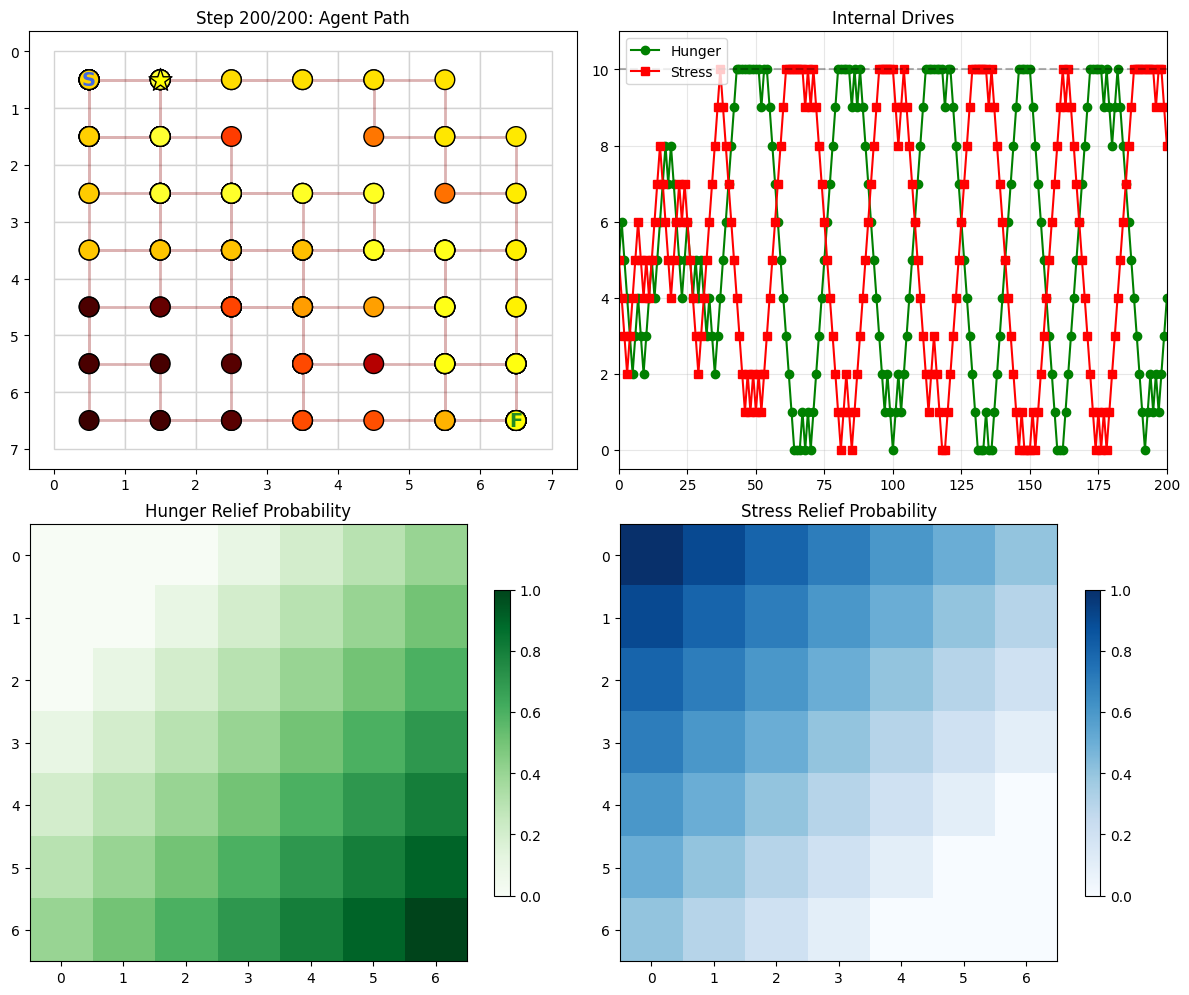

Experiment 2 Finished.


In [67]:
# === Experiment 2: Distance-Dependent Penalties ===

# 1. Start with same grid dimensions and max levels
# New locations: Opposite corners
food_location2 = (6, 6)      # Bottom-right
shelter_location2 = (0, 0)   # Top-left (unchanged)

# Pre-compute indices for new locations
food_idx2 = loc_list.index(food_location2)
shelter_idx2 = loc_list.index(shelter_location2)

print("Experiment 2 Setup:")
print(f"  Food: {food_location2}, Shelter: {shelter_location2}")

reward_likelihood_scale = 0.1  # How quickly the "scent" of food/shelter decays with distance

# 2. Define Custom Environment with "Spread Out" Penalties
class GridWorldEnvDistancePenalty(GridWorldEnv):
    def __init__(self, starting_loc, initial_hunger, initial_stress, food_location, shelter_location, 
                 grid_dims, max_hunger, max_stress, loc_list, hunger_levels, stress_levels,
                 hunger_sensor_names, stress_sensor_names):
        self.init_loc = starting_loc
        self.init_hunger = initial_hunger
        self.init_stress = initial_stress
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_stress = self.init_stress

        self.food_location = food_location
        self.shelter_location = shelter_location
        self.grid_dims = grid_dims
        self.max_hunger = max_hunger
        self.max_stress = max_stress
        self.loc_list = loc_list
        self.hunger_levels = hunger_levels
        self.stress_levels = stress_levels
        self.hunger_sensor_names = hunger_sensor_names
        self.stress_sensor_names = stress_sensor_names

        print(f'Environment Initialized: Starting location is {self.init_loc}, Initial hunger is {self.init_hunger}, Initial stress is {self.init_stress}')

    def step(self, action_label):

        # Distance calculations
        dist_food = abs(self.current_location[0]-self.food_location[0]) + abs(self.current_location[1]-self.food_location[1])
        dist_shelter = abs(self.current_location[0]-self.shelter_location[0]) + abs(self.current_location[1]-self.shelter_location[1])

        # New Hunger Logic
        # Linear gradient to ensure "scent" is visible everywhere
        p_h = max(0.0, 1.0 - (dist_food * reward_likelihood_scale))
        
        if np.random.rand() < p_h:
            dh = -1
        else:
            dh = 1 # Natural increase if reward missed
            
        self.current_hunger = int(np.clip(self.current_hunger + dh, 0, self.max_hunger))

        # New Stress Logic
        p_s = max(0.0, 1.0 - (dist_shelter * reward_likelihood_scale))
            
        if np.random.rand() < p_s:
            ds = -1
        else:
            ds = 1
            
        self.current_stress = int(np.clip(self.current_stress + ds, 0, self.max_stress))

        Y, X = self.current_location
        if action_label == "UP":
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X
        elif action_label == "DOWN":
          Y_new = Y + 1 if Y < (self.grid_dims[0]-1) else Y
          X_new = X
        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X
        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X + 1 if X < (self.grid_dims[1]-1) else X
        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new)

        # Observations
        loc_obs = self.current_location
        # Map values to closest available level if needed, but here levels are just integers
        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]
        stress_obs = self.stress_sensor_names[self.stress_levels.tolist().index(self.current_stress)]

        return loc_obs, hunger_obs, stress_obs
    

# 3. New B Matrices with Distance-Based Transitions
# We now link hunger state transitions (whether it increases or decreases) to location state.
# The agent knows that certain locations have a higher likelyhood of hunger and stress increasing or decreasing.
# If it is really hungry, it will prefer states with a higher chance of hunger decreasing (i.e. closer to food). 
# If it is really stressed, it will prefer states with a higher chance of stress decreasing (i.e. closer to shelter).
# This sets up a reward liklihood gradient, allowing the agent to form policies with a short horizon that move towards likely sources of a resource scaled by the need for that resource.
# This is in contrast to Experiment 1 where the agent only gets feedback when it is directly on top of the resource, which requires a policy horizon that spans the entire journey in order to see any value in it.

B2 = utils.obj_array(len(num_states))

# B[0] (Location) - Same as before (Standard movement)
B2[0] = B[0].copy()

# B[1] (Hunger) - Distance dependent
B2[1] = np.zeros((num_hunger, num_grid_points, num_hunger, num_controls[1]))
print("Building B2[1] (Hunger)...")

for loc_idx in range(num_grid_points):
    curr_y, curr_x = loc_list[loc_idx]
    dist = abs(curr_y - food_location2[0]) + abs(curr_x - food_location2[1])
    
    # Linear gradient matching environment
    p_h = max(0.0, 1.0 - (dist * reward_likelihood_scale)) # 0.5
        
    for h in range(num_hunger):
        # Two possible outcomes:
        # 1. Reward (-1) with prob p_h
        # 2. No reward (+1) with prob 1-p_h
        
        next_h_dec = max(0, h - 1)
        next_h_inc = min(max_hunger, h + 1)
        
        if next_h_dec == next_h_inc: # Edge case if max_hunger=0? unlikely
             B2[1][next_h_dec, loc_idx, h, 0] = 1.0
        else:
            B2[1][next_h_dec, loc_idx, h, 0] += p_h
            B2[1][next_h_inc, loc_idx, h, 0] += (1.0 - p_h)

# B[2] (Stress) - Distance dependent
B2[2] = np.zeros((num_stress, num_grid_points, num_stress, num_controls[2]))
print("Building B2[2] (Stress)...")

for loc_idx in range(num_grid_points):
    curr_y, curr_x = loc_list[loc_idx]
    dist = abs(curr_y - shelter_location2[0]) + abs(curr_x - shelter_location2[1])
    
    # Linear gradient matching environment
    p_s = max(0.0, 1.0 - (dist * reward_likelihood_scale)) # 0.5
        
    for r in range(num_stress):
        next_r_dec = max(0, r - 1)
        next_r_inc = min(max_stress, r + 1)
        
        if next_r_dec == next_r_inc:
             B2[2][next_r_dec, loc_idx, r, 0] = 1.0
        else:
            B2[2][next_r_dec, loc_idx, r, 0] += p_s
            B2[2][next_r_inc, loc_idx, r, 0] += (1.0 - p_s)

# Verify B2
for i, b_fac in enumerate(B2):
    if not np.allclose(b_fac.sum(axis=0), 1.0):
        print(f"Warning: B2[{i}] not normalized!")

# 4. New A Matrices (Observation Model)
# A matrix is now an IDENTITY mapping, e.g if the agent IS hungry it will OBSERVE that it is hungry.

A2 = utils.obj_array(len(num_obs))
A2[0] = A[0].copy()

# A[1] Hunger - Identity Mapping (Interoception is accurate)
A2[1] = np.zeros((num_obs[1], num_grid_points, num_hunger, num_stress))
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_stress):
            # We observe exactly what state we are in, regardless of location
            A2[1][h, loc_idx, h, r] = 1.0

# A[2] Stress - Identity Mapping
A2[2] = np.zeros((num_obs[2], num_grid_points, num_hunger, num_stress))
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_stress):
            # We observe exactly what state we are in, regardless of location
            A2[2][r, loc_idx, h, r] = 1.0

print("Updated A2 matrices to be Identity Mappings (probabilistic logic is now isolated in B2).")

# 5. Run Simulation
initial_hunger2 = max_hunger // 2
initial_stress2 = max_stress // 2
starting_loc2 = (grid_dims[0] // 2, grid_dims[1] // 2) # Start in middle

my_env2 = GridWorldEnvDistancePenalty(
    starting_loc=starting_loc2,
    initial_hunger=initial_hunger2,
    initial_stress=initial_stress2,
    food_location=food_location2,
    shelter_location=shelter_location2,
    grid_dims=grid_dims,
    max_hunger=max_hunger,
    max_stress=max_stress,
    loc_list=loc_list,
    hunger_levels=hunger_levels,
    stress_levels=stress_levels,
    hunger_sensor_names=hunger_sensor_names,
    stress_sensor_names=stress_sensor_names
)

# Update Initial Belief D
D2 = utils.obj_array_uniform(num_states)
D2[0] = utils.onehot(loc_list.index(starting_loc2), num_grid_points)
D2[1] = utils.onehot(initial_hunger2, num_hunger)
D2[2] = utils.onehot(initial_stress2, num_stress)

# Agent
my_agent2 = Agent(
    A=A2, 
    B=B2, 
    C=C, 
    D=D2, 
    policy_len=2, 
    B_factor_list=B_factor_list,

    ## B-learning
    # pB=utils.dirichlet_like(B), # Prior over B. Updated based on how often transition predictions are correct (the more times we see a transition, the more confident we are in it)
    # save_belief_hist=True, # So we can compare our predicted transitions to actual transitions
    # lr_pB=1, # learning rate
    # use_param_info_gain=True, # Place value on actions that reduce uncertainty about B

    ## Inference algorithm
    # inference_algo="MMP", # Keeps a short history of observations and actions, and for each possible future plan it infers beliefs over a window of time (past + future). This gives richer, policy-specific beliefs but costs more memory 
    # inference_horizon=2,
    # use_BMA=False, # Baysian Model Averaging - predict future observations by averaging over all policies, weighted by their probabilities. This is more efficient but less precise.
    # policy_sep_prior=True, # Maintain separate beliefs for each policy (instead of BMA). This allows for more precise, policy-specific beliefs but costs more memory.
    
    ## Policy pruning to manage combinatorial explosion of sophisticated inference
    # sophisticated=True, # At each policy timestep, rather than just score the current transition also score possible future transitions up to the si_horizon, weighted by their likelihood. Allows early pruning of high EFE policies and unlikely states.
    # si_horizon=2, # Simulation horizon for sophisticated inference.
    # si_policy_prune_threshold=1/8, # Threshold for pruning policies during sophisticated inference. A policy with posterior probability below 1/8 (12.5%) is pruned.
    # si_state_prune_threshold=1/8, # Threshold for pruning states during sophisticated inference. An observation outcome branch with joint probability below 1/8 (12.5%) is skipped.
    # si_prune_penalty=512, # EFE penalty applied when pruning during sophisticated inference, penalising the policy in the final scoring. Should be large enough that the pruned policy won't be chosen.

    control_fac_idx=control_fac_idx)

# Loop
from IPython.display import clear_output, display
import time

# Timesteps
T2 = 200

history_of_locs2 = [starting_loc2]
history_of_hunger2 = [initial_hunger2]
history_of_stress2 = [initial_stress2]
obs2 = my_env2.reset() 
obs2 = [loc_list.index(obs2[0]), hunger_sensor_names.index(obs2[1]), stress_sensor_names.index(obs2[2])]

# Pre-calculate Heatmaps for visualization efficiency
hunger_grid = np.zeros(grid_dims)
stress_grid = np.zeros(grid_dims)
for y in range(grid_dims[0]):
    for x in range(grid_dims[1]):
         d_f = abs(y - food_location2[0]) + abs(x - food_location2[1])
         hunger_grid[y, x] = max(0.0, 1.0 - (d_f * reward_likelihood_scale))
         d_s = abs(y - shelter_location2[0]) + abs(x - shelter_location2[1])
         stress_grid[y, x] = max(0.0, 1.0 - (d_s * reward_likelihood_scale))

print("\nStarting Experiment 2 Simulation...")

for t in range(T2):
    # --- Agent Step ---
    qs = my_agent2.infer_states(obs2)
    my_agent2.infer_policies()
    action_idx = int(my_agent2.sample_action()[0])
    action = actions[action_idx]

    # Only enable if B learning is turned on in the Agent constructor otherwise the history won't be available and B param info gain won't be calculated
    # if t > 0:  
    #     my_agent2.update_B(qs_prev=my_agent2.qs_hist[-2])
    
    loc_obs, hunger_obs, stress_obs = my_env2.step(action)
    
    obs2 = [loc_list.index(loc_obs), hunger_sensor_names.index(hunger_obs), stress_sensor_names.index(stress_obs)]
    
    history_of_locs2.append(loc_obs)
    history_of_hunger2.append(my_env2.current_hunger)
    history_of_stress2.append(my_env2.current_stress)

    # --- Live Visualization ---
    clear_output(wait=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Agent Path (Top Left)
    ax_path = axes[0, 0]
    ax_path.set_title(f"Step {t+1}/{T2}: Agent Path")
    ax_path.invert_yaxis()
    
    # Grid Background
    for y in range(grid_dims[0]):
        for x in range(grid_dims[1]):
            rect = patches.Rectangle((x, y), 1.0, 1.0, linewidth=1, edgecolor='lightgray', facecolor='white')
            ax_path.add_patch(rect)
    
    # Trajectory & Current Position
    hist_locs = np.vstack(history_of_locs2).astype(float)
    temporal_colormap = cm.hot(np.linspace(0, 0.8, len(hist_locs)))
    
    # Path line
    if len(hist_locs) > 1:
        ax_path.plot(hist_locs[:,1]+0.5, hist_locs[:,0]+0.5, 'darkred', linewidth=2, zorder=2, alpha=0.3)
    
    # Points
    ax_path.scatter(hist_locs[:,1]+0.5, hist_locs[:,0]+0.5, 200, c=temporal_colormap, zorder=3, edgecolors='black')
    
    # Current Head
    current_head = hist_locs[-1]
    ax_path.scatter(current_head[1]+0.5, current_head[0]+0.5, 300, c='yellow', marker='*', zorder=4, edgecolors='black', label='Current')

    # Markers
    ax_path.text(food_location2[1]+0.5, food_location2[0]+0.5, 'F', ha='center', va='center', fontweight='bold', color='forestgreen', fontsize=14)
    ax_path.text(shelter_location2[1]+0.5, shelter_location2[0]+0.5, 'S', ha='center', va='center', fontweight='bold', color='royalblue', fontsize=14)

    # 2. Stats (Top Right)
    ax_stats = axes[0, 1]
    ax_stats.set_title("Internal Drives")
    ax_stats.plot(history_of_hunger2, 'g-o', label='Hunger')
    ax_stats.plot(history_of_stress2, 'r-s', label='Stress')
    ax_stats.axhline(y=max_hunger, color='k', linestyle='--', alpha=0.3)
    ax_stats.set_xlim(0, T2)
    ax_stats.set_ylim(-0.5, max(max_hunger, max_stress)+1)
    ax_stats.legend(loc='upper left')
    ax_stats.grid(True, alpha=0.3)

    # 3. Hunger Map (Bottom Left)
    ax_map1 = axes[1, 0]
    ax_map1.set_title("Hunger Relief Probability")
    im1 = ax_map1.imshow(hunger_grid, cmap='Greens', vmin=0, vmax=1.0)
    fig.colorbar(im1, ax=ax_map1, shrink=0.7)
    
    # 4. Stress Map (Bottom Right)
    ax_map2 = axes[1, 1]
    ax_map2.set_title("Stress Relief Probability")
    im2 = ax_map2.imshow(stress_grid, cmap='Blues', vmin=0, vmax=1.0)
    fig.colorbar(im2, ax=ax_map2, shrink=0.7)
    
    plt.tight_layout()
    plt.show()

print("Experiment 2 Finished.")

# Experiment 3: Epistemic Chaining with Competing Drives

This experiment builds on Experiment 1 and offers a twist on the cue-chaining example found in the pymdp repo.

Similarly to Experiment 1, we have two goals which provide relief from competing drives.

This time however, each goal could be in one of two locations with 50% probability.

There is a 'cue' square in the corners furthest away from the potential goals. Moving on to them is always a move away from the goal.

If the agent lands on them, its observation removes all uncertainty about the world state.

It gets clear information about both goal locations - now it knows with 100% probability which to pick.

This is acheived by having two new hidden states (true location of each goal).

They have two possible values (Location 1 or 2).

If the agent is at any other square than the cue, it observes Null which doesn't provide any information.

If it is on the cue square, its observation includes the true locations, so it updates its state prediction to reflect that.

The A matrix has pre-encoded info
- If you aren't on Cue, expect to observe Null true goal location info
- If you are on Cue, expect to observe clear true goal information
- 

In [96]:
# === Experiment 3: Setup ===

# 1. Grid & Locations
grid_dims_3 = [4, 4]
num_grid_points_3 = int(np.prod(grid_dims_3))

# Create location lookup
loc_list_3 = []
for y in range(grid_dims_3[0]):
    for x in range(grid_dims_3[1]):
        loc_list_3.append((y, x))

# Locations
shelter_locs_3 = [(1, 0), (2, 1)]  # Top-Edge, Left-Edge
food_locs_3 = [(2, 3), (3, 2)]     # Right-Edge, Bottom-Edge

# Cues
# Assume (0,3) reveals Food Context and (3,0) reveals Shelter Context
# or simplistically, they act as "Info" locations.
# User Requirements: "Cues provides 100% info about the true Food and Shelter modalities"
# "Cue locations at 0,3 and 3,0"
# Both cues reveal BOTH contexts.
# Let's map: Cue(0,3) -> Cue A. Cue(3,0) -> Cue B.
cue1_loc_3 = (0, 3)     # Top-Right
cue2_loc_3 = (3, 0)     # Bottom-Left

print("Experiment 3 Config:")
print(f"  Grid: {grid_dims_3}")
print(f"  Food Candidates: {food_locs_3}")
print(f"  Shelter Candidates: {shelter_locs_3}")
print(f"  Cue A: {cue1_loc_3}, Cue B: {cue2_loc_3}")

# 2. State Factors
# [Location, Hunger, Stress, FoodContext, ShelterContext]
n_hunger_3 = 7  # 0-8
n_stress_3 = 7  # 0-8

# Contexts: State 0 -> Loc 0 (1st in list), State 1 -> Loc 1 (2nd in list)
# FoodContext=0: Food at (2,3). FoodContext=1: Food at (3,2).
# ShelterContext=0: Shelter at (0,1). ShelterContext=1: Shelter at (1,0).
num_states_3 = [
    num_grid_points_3, # Location (16)
    n_hunger_3,        # Hunger (8)
    n_stress_3,        # Stress (8)
    2,                 # FoodContext (2)
    2                  # ShelterContext (2)
]

# 3. Observations
# [Location(16), Hunger(6), Stress(6), FoodCue(3), ShelterCue(3)]
# Cue Obs Levels: 0=Null, 1=Context0, 2=Context1
num_obs_3 = [
    num_grid_points_3, # Loc
    n_hunger_3,        # Hunger Sensor
    n_stress_3,        # Stress Sensor
    3,                 # Food Cue Obs (Null, Hint0, Hint1)
    3                  # Shelter Cue Obs (Null, Hint0, Hint1)
]

print(f"  State Factors: {num_states_3}")
print(f"  Observations: {num_obs_3}")

# 4. Generate A Matrices
A3 = utils.obj_array_zeros([[n] + num_states_3 for n in num_obs_3])

# Fill A3
for loc_idx in range(num_grid_points_3):
    loc_yx = loc_list_3[loc_idx]
    
    for h in range(n_hunger_3):
        for s in range(n_stress_3):
            for f_ctx in range(2):
                for s_ctx in range(2):
                    # A3[0] Location: Identity
                    A3[0][loc_idx, loc_idx, h, s, f_ctx, s_ctx] = 1.0
                    
                    # A3[1] Hunger Sensor:
                    A3[1][h, loc_idx, h, s, f_ctx, s_ctx] = 1.0
                    
                    # A3[2] Stress Sensor:
                    A3[2][s, loc_idx, h, s, f_ctx, s_ctx] = 1.0
                        
                    # A3[3] Food Cue Obs - reveals FoodCtx at cues AND at food candidate locations
                    # A3[4] Shelter Cue Obs - reveals ShelterCtx at cues AND at shelter candidate locations
                    # This allows learning from visiting false reward locations
                    
                    # Check if at a cue (reveals both contexts)
                    at_cue = (loc_yx == cue1_loc_3 or loc_yx == cue2_loc_3)
                    # Check if at a food candidate (reveals food context)
                    at_food_candidate = (loc_yx in food_locs_3)
                    # Check if at a shelter candidate (reveals shelter context)
                    at_shelter_candidate = (loc_yx in shelter_locs_3)
                    
                    # Food Cue observation
                    if at_cue or at_food_candidate:
                        A3[3][f_ctx + 1, loc_idx, h, s, f_ctx, s_ctx] = 1.0
                    else:
                        A3[3][0, loc_idx, h, s, f_ctx, s_ctx] = 1.0  # Null
                    
                    # Shelter Cue observation
                    if at_cue or at_shelter_candidate:
                        A3[4][s_ctx + 1, loc_idx, h, s, f_ctx, s_ctx] = 1.0
                    else:
                        A3[4][0, loc_idx, h, s, f_ctx, s_ctx] = 1.0  # Null
                        

print("A3 matrices constructed.")

Experiment 3 Config:
  Grid: [4, 4]
  Food Candidates: [(2, 3), (3, 2)]
  Shelter Candidates: [(1, 0), (2, 1)]
  Cue A: (0, 3), Cue B: (3, 0)
  State Factors: [16, 7, 7, 2, 2]
  Observations: [16, 7, 7, 3, 3]
A3 matrices constructed.


In [97]:
# 5. Generate B Matrices
# Factors: [Loc, Hunger, Stress, FoodCtx, ShelterCtx]
# B_factor_list:
#   Loc(0) -> [0]
#   Hunger(1) -> [0, 1, 3] (Loc, Hunger)
#   Stress(2) -> [0, 2, 4] (Loc, Stress)
#   FoodCtx(3) -> [3] (Static, depends on self)
#   ShelterCtx(4) -> [4] (Static, depends on self)

num_controls_3 = [5, 1, 1, 1, 1] # Only Loc is controllable
control_fac_idx_3 = [0]
B_factor_list_3 = [[0], [0, 3, 1], [0, 4, 2], [3], [4]]

B3 = utils.obj_array(len(num_states_3))

# B3[0] Location (Standard Grid)
B3[0] = np.zeros((num_grid_points_3, num_grid_points_3, num_controls_3[0]))
for action_id, action_label in enumerate(actions):
    for curr_loc_idx in range(num_grid_points_3):
        curr_y, curr_x = loc_list_3[curr_loc_idx]
        if action_label == "UP":
            next_y = curr_y - 1 if curr_y > 0 else curr_y
            next_x = curr_x
        elif action_label == "DOWN":
            next_y = curr_y + 1 if curr_y < (grid_dims_3[0]-1) else curr_y
            next_x = curr_x
        elif action_label == "LEFT":
            next_y = curr_y
            next_x = curr_x - 1 if curr_x > 0 else curr_x
        elif action_label == "RIGHT":
            next_y = curr_y
            next_x = curr_x + 1 if curr_x < (grid_dims_3[1]-1) else curr_x
        elif action_label == "STAY":
            next_y, next_x = curr_y, curr_x
        next_loc_idx = loc_list_3.index((next_y, next_x))
        B3[0][next_loc_idx, curr_loc_idx, action_id] = 1.0

# B3[1] Hunger: Depends on Loc, true Food location, Hunger
# Shape: (NextH, Loc, FoodCtx, CurrH, Action)
B3[1] = np.zeros((n_hunger_3, num_grid_points_3, 2, n_hunger_3, 1))

for loc_idx in range(num_grid_points_3):
    loc_yx = loc_list_3[loc_idx]
    for curr_h in range(n_hunger_3):
        for f_ctx in range(2):
            true_food_loc = food_locs_3[f_ctx]
            if loc_yx == true_food_loc:
                # Reset if at TRUE food location
                next_h = 0
            else:
                next_h = min(curr_h + 1, n_hunger_3 - 1)
            B3[1][next_h, loc_idx, f_ctx, curr_h, 0] = 1.0

# B3[2] Stress: Depends on Loc, true Shelter location, Stress
# Shape: (NextS, Loc, ShelterCtx, CurrS, Action)
B3[2] = np.zeros((n_stress_3, num_grid_points_3, 2, n_stress_3, 1))

for loc_idx in range(num_grid_points_3):
    loc_yx = loc_list_3[loc_idx]
    for curr_s in range(n_stress_3):
        for s_ctx in range(2):
            true_shelter_loc = shelter_locs_3[s_ctx]
            if loc_yx == true_shelter_loc:
                # Reset if at TRUE shelter location
                next_s = 0
            else:
                next_s = min(curr_s + 1, n_stress_3 - 1)
            B3[2][next_s, loc_idx, s_ctx, curr_s, 0] = 1.0

# B3[3] & B3[4] Contexts: Identity (Static)
B3[3] = np.eye(2).reshape(2, 2, 1)
B3[4] = np.eye(2).reshape(2, 2, 1)

print("B3 matrices constructed with context-dependent dynamics.")

B3 matrices constructed with context-dependent dynamics.


In [101]:
# 6. C and D Matrices
C3 = utils.obj_array_zeros(num_obs_3)

# Lower penalty magnitude to allow Epistemic Value (~0.7 nats) to compete with Instrumental Value
# If penalty is -50, the agent is too afraid to explore. 
# Values around -2.0 to -5.0 are better for epistemic foraging.
penalty_max = -2.0

# Higher numbers reduce extrinsic penalty so encourage epistemic foraging
# At 4 it will risk a reward miss over info
# At 8, it will prefer info to a reward gamble
exp_steepness = 8.0

# Hunger Preferences
n_hunger = len(C3[1])
C3[1][-1] =  penalty_max
for i in range(n_hunger):
    denominator = n_hunger - 1
    progress = i / denominator if denominator > 0 else 1.0
    scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
    C3[1][i] = penalty_max * scale

# Stress Preferences - Symmetrical
n_stress = len(C3[2])
C3[2][-1] = penalty_max
for i in range(n_stress):
    denominator = n_stress - 1
    progress = i / denominator if denominator > 0 else 1.0
    scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
    C3[2][i] = penalty_max * scale

# No preferences for Cues or Location (Instrumental only)

# D Matrix - Priors
D3 = utils.obj_array_uniform(num_states_3)

# Scenario (0 or 1 to select which candidate is real)
true_f_ctx = 1
true_s_ctx = 1

# (0,2) is between shelter candidate and info
# (1,3) is between food candidate and info
# (1,2) is between shelter and food candidates
start_node_3 = (1,3)
start_node_idx_3 = loc_list_3.index(start_node_3)

# Example scenarios (all can change with tweaks to penalties and preferences)
# Agent between info and reward, high penalty for exposure, chooses info
# Agent between info and reward, low penalty for exposure, chooses reward gamble
# Agent between shelter and food, hungry, chooses food gamble
# Agent between shelter and food, stressed, chooses shelter gamble
# Agent between shelter and food, not hungry or stressed, random gamble
# Agent chooses info and one reward is closer than the other, will always pick the closer
# Agent chooses info and both rewards are equidistant, will be biased by hunger vs stress
# Agent between both cases of a reward and far from info chooses gamble

# Depending on whether the gamble is a hit or miss, the agent can end up super hungry or stressed in the worst case scenario
# e.g. gets info and discovers the resources are both in the opposite direction

# If equidistant from a food and shelter candidate, an agents choice can be biased by starting with hunger or stress
starting_hunger = 0
starting_stress = 0

D3[0] = utils.onehot(start_node_idx_3, num_grid_points_3)
D3[1] = utils.onehot(starting_hunger, n_hunger_3) 
D3[2] = utils.onehot(starting_stress, n_stress_3)

# Crucial: High Entropy Priors for Contexts
D3[3] = np.array([0.5, 0.5]) # Don't know where food is
D3[4] = np.array([0.5, 0.5]) # Don't know where shelter is

print("C3 and D3 initialized.")
print("Context Priors set to 0.5/0.5 (Maximum Uncertainty)")

C3 and D3 initialized.
Context Priors set to 0.5/0.5 (Maximum Uncertainty)


In [102]:
# 7. Epistemic Environment Class
class EpistemicGridWorld:
    def __init__(self, dims, loc_list, food_locs, shelter_locs, cue1_loc, cue2_loc):
        self.dims = dims
        self.loc_list = loc_list
        self.food_locs = food_locs
        self.shelter_locs = shelter_locs
        self.cue1_loc = cue1_loc
        self.cue2_loc = cue2_loc
        
        # True State
        self.loc = None
        self.hunger = 0
        self.stress = 0
        self.food_ctx = 0 # 0 or 1
        self.shelter_ctx = 0 # 0 or 1
        
        # Parameters
        self.max_hunger = n_hunger_3 - 1
        self.max_stress = n_stress_3 - 1

    def reset(self, start_loc, f_ctx=0, s_ctx=0, start_hunger=0, start_stress=0):
        self.loc = start_loc
        self.food_ctx = f_ctx
        self.shelter_ctx = s_ctx
        self.hunger = start_hunger
        self.stress = start_stress
        
        return self.get_obs()

    def step(self, action_label):
        # Dynamics
        true_food = self.food_locs[self.food_ctx]
        true_shelter = self.shelter_locs[self.shelter_ctx]
        
        if self.loc == true_food:
            self.hunger = 0
        else:
            self.hunger = min(self.hunger + 1, self.max_hunger)
            
        if self.loc == true_shelter:
            self.stress = 0
        else:
            self.stress = min(self.stress + 1, self.max_stress)
            
        # Move
        y, x = self.loc
        if action_label == "UP": y = max(0, y-1)
        elif action_label == "DOWN": y = min(self.dims[0]-1, y+1)
        elif action_label == "LEFT": x = max(0, x-1)
        elif action_label == "RIGHT": x = min(self.dims[1]-1, x+1)
        self.loc = (y, x)
        
            
        return self.get_obs()

    def get_obs(self):
        # [LocIdx, Hunger, Stress, FoodCue, ShelterCue]
        loc_idx = self.loc_list.index(self.loc)
        
        at_cue = (self.loc == self.cue1_loc or self.loc == self.cue2_loc)
        at_food_candidate = (self.loc in self.food_locs)
        at_shelter_candidate = (self.loc in self.shelter_locs)
        
        # Food Context Obs - revealed at cues AND food candidate locations
        if at_cue or at_food_candidate:
            f_cue = self.food_ctx + 1  # 1 or 2
        else:
            f_cue = 0  # Null
            
        # Shelter Context Obs - revealed at cues AND shelter candidate locations
        if at_cue or at_shelter_candidate:
            s_cue = self.shelter_ctx + 1
        else:
            s_cue = 0
            
        return [loc_idx, self.hunger, self.stress, f_cue, s_cue]

print("EpistemicGridWorld class defined.")

EpistemicGridWorld class defined.


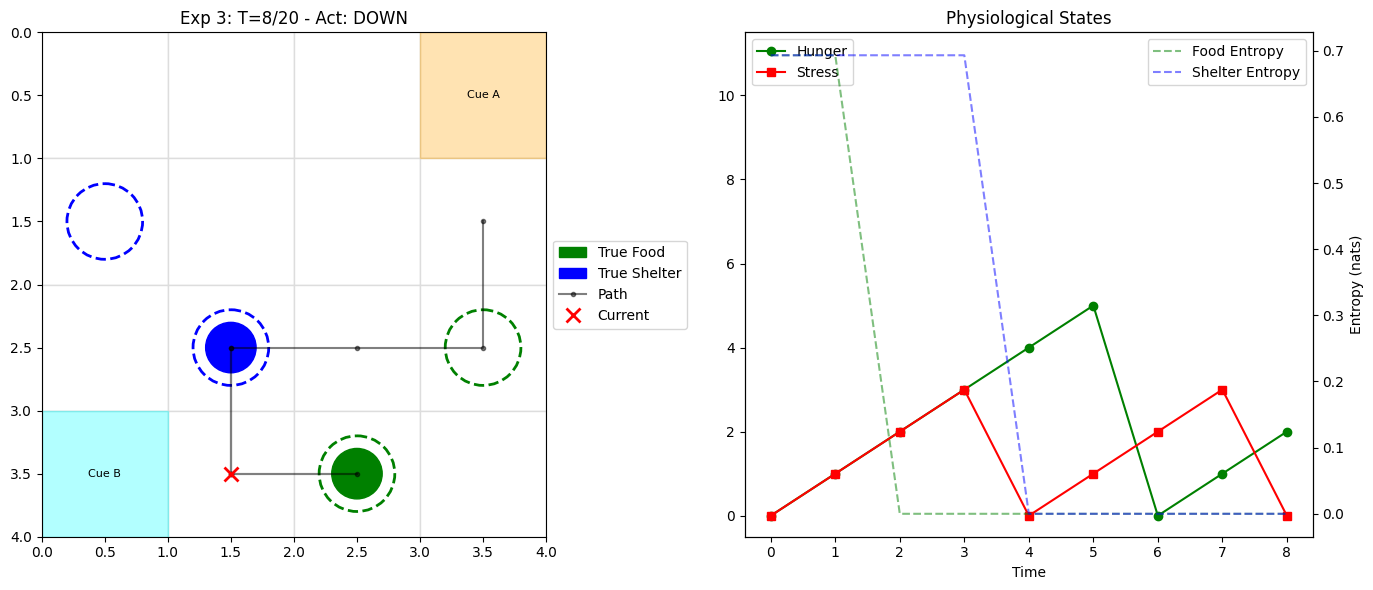

Loc: (3, 1), Hunger: 2, Stress: 0


KeyboardInterrupt: 

In [103]:
from IPython.display import clear_output, display
import time

# 8. Run Experiment 3 with Live Visualization
env3 = EpistemicGridWorld(
    grid_dims_3, loc_list_3, food_locs_3, shelter_locs_3, cue1_loc_3, cue2_loc_3
)

# Initialize Agent
agent3 = Agent(
    A=A3, B=B3, C=C3, D=D3,
    policy_len=5, 
    B_factor_list=B_factor_list_3,
    control_fac_idx=control_fac_idx_3
)

# Use Experiment 3 specific start parameters (starting_hunger, starting_stress)
obs = env3.reset(start_node_3, f_ctx=true_f_ctx, s_ctx=true_s_ctx, start_hunger=starting_hunger, start_stress=starting_stress)

T3 = 20
hist_locs_3 = [env3.loc]
hist_hunger_3 = [env3.hunger]
hist_stress_3 = [env3.stress]
# Track belief entropy about Food Context
hist_context_food = [agent3.qs[3].copy()]
hist_context_shelter = [agent3.qs[4].copy()]

print(f"Starting Epistemic Chaining Experiment...")

def get_entropy(dist):
    return -np.sum(dist * np.log(dist + 1e-16))

for t in range(T3):
    # Agent Action
    qs = agent3.infer_states(obs)
    agent3.infer_policies()
    action_idx = int(agent3.sample_action()[0])
    action = actions[action_idx]
    
    # Store beliefs
    hist_context_food.append(qs[3].copy())
    hist_context_shelter.append(qs[4].copy())
    
    # Step Environment
    obs = env3.step(action)
    
    # Update History
    hist_locs_3.append(env3.loc)
    hist_hunger_3.append(env3.hunger)
    hist_stress_3.append(env3.stress)

    # --- Live Visualization ---
    clear_output(wait=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Map
    ax_map = axes[0]
    ax_map.set_xlim(0, 4)
    ax_map.set_ylim(4, 0)
    ax_map.set_aspect('equal')
    ax_map.set_title(f"Exp 3: T={t+1}/{T3} - Act: {action}")

    # Grid Lines
    for y in range(4):
        for x in range(4):
            rect = patches.Rectangle((x, y), 1, 1, linewidth=1, edgecolor='#ddd', facecolor='white')
            ax_map.add_patch(rect)

    # Draw Features
    # Cues
    ax_map.add_patch(patches.Rectangle((cue1_loc_3[1], cue1_loc_3[0]), 1, 1, color='orange', alpha=0.3))
    ax_map.text(cue1_loc_3[1]+0.5, cue1_loc_3[0]+0.5, "Cue A", ha='center', va='center', fontsize=8)

    ax_map.add_patch(patches.Rectangle((cue2_loc_3[1], cue2_loc_3[0]), 1, 1, color='cyan', alpha=0.3))
    ax_map.text(cue2_loc_3[1]+0.5, cue2_loc_3[0]+0.5, "Cue B", ha='center', va='center', fontsize=8)

    # Potential Rewards (Hollow)
    for fl in food_locs_3:
        ax_map.add_patch(patches.Circle((fl[1]+0.5, fl[0]+0.5), 0.3, fill=False, edgecolor='green', linewidth=2, linestyle='--'))
    for sl in shelter_locs_3:
        ax_map.add_patch(patches.Circle((sl[1]+0.5, sl[0]+0.5), 0.3, fill=False, edgecolor='blue', linewidth=2, linestyle='--'))

    # True Rewards (Solid) - Cheat for viz
    true_f = food_locs_3[true_f_ctx]
    true_s = shelter_locs_3[true_s_ctx]
    ax_map.add_patch(patches.Circle((true_f[1]+0.5, true_f[0]+0.5), 0.2, color='green', label='True Food'))
    ax_map.add_patch(patches.Circle((true_s[1]+0.5, true_s[0]+0.5), 0.2, color='blue', label='True Shelter'))

    # Path
    locs_arr = np.array(hist_locs_3)
    ax_map.plot(locs_arr[:,1]+0.5, locs_arr[:,0]+0.5, 'k.-', alpha=0.5, label='Path')
    ax_map.plot(locs_arr[-1,1]+0.5, locs_arr[-1,0]+0.5, 'rx', markersize=10, markeredgewidth=2, label='Current')
    ax_map.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Stats
    ax_stats = axes[1]
    ax_stats.plot(hist_hunger_3, 'g-o', label='Hunger')
    ax_stats.plot(hist_stress_3, 'r-s', label='Stress')
    ax_stats.set_title("Physiological States")
    ax_stats.set_ylim(-0.5, 11.5)
    ax_stats.set_xlabel("Time")
    ax_stats.legend(loc='upper left')

    # Entropy (Uncertainty)
    ax_ent = ax_stats.twinx()
    k_food = [get_entropy(d) for d in hist_context_food]
    k_shelter = [get_entropy(d) for d in hist_context_shelter]
    
    ax_ent.plot(k_food, 'g--', label='Food Entropy', alpha=0.5)
    ax_ent.plot(k_shelter, 'b--', label='Shelter Entropy', alpha=0.5)
    
    ax_ent.set_ylabel("Entropy (nats)")
    ax_ent.legend(loc='upper right')

    plt.tight_layout()
    display(fig)
    plt.close(fig) # Prevent double plotting
    
    # Print status
    print(f"Loc: {env3.loc}, Hunger: {env3.hunger}, Stress: {env3.stress}")
    if env3.loc == env3.cue1_loc: print("  [!] Observed Cue A!")
    if env3.loc == env3.cue2_loc: print("  [!] Observed Cue B!")
    if env3.loc == food_locs_3[true_f_ctx]: print("  [+] Found Food!")
    if env3.loc == shelter_locs_3[true_s_ctx]: print("  [+] Found Shelter!")
    
print("Experiment Finished.")